# EDA

In [286]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import xgboost as xgb

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from pmdarima import auto_arima
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller

In [287]:
data = pd.read_csv('01_02_Data_cleaned_Client1.csv')

In [288]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83235 entries, 0 to 83234
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   EventName           83235 non-null  object 
 1   StartDate           83235 non-null  object 
 2   EventType           83235 non-null  object 
 3   BookingReference    83235 non-null  object 
 4   AttendeeReference   83235 non-null  object 
 5   GroupSize           83235 non-null  int64  
 6   IsLeadAttendee      83235 non-null  bool   
 7   AttendeeGrossCost   83235 non-null  float64
 8   EventId             83235 non-null  int64  
 9   BookingStatus       83235 non-null  object 
 10  AttendeeType        83235 non-null  object 
 11  TicketType          83235 non-null  object 
 12  StatusCreatedDate   83235 non-null  object 
 13  ClientId            83235 non-null  int64  
 14  StartYear           83235 non-null  int64  
 15  StartMonth          83235 non-null  int64  
 16  Stat

In [289]:
data.head(10)

,EventName,StartDate,EventType,BookingReference,AttendeeReference,GroupSize,IsLeadAttendee,AttendeeGrossCost,EventId,BookingStatus,AttendeeType,TicketType,StatusCreatedDate,ClientId,StartYear,StartMonth,StatusCreatedYear,StatusCreatedMonth,StartWeek,StatusCreatedWeek
0,Neoliberalism. the Family. and Bourgeois Domes...,2021-10-12 15:00:00,Seminar,B953419,A1021430,1,True,0.0,24077,Attending,Attendee,Standard,2021-05-03 16:27:00,219,2021,10,2021,5,41,18
1,Queer Homemaking I,2021-10-22 15:00:00,Reading Group,B954541,A1022562,1,True,0.0,24071,Attending,Attendee,Standard,2021-08-03 17:02:00,219,2021,10,2021,8,42,31
2,Neoliberalism. the Family. and Bourgeois Domes...,2021-10-12 15:00:00,Seminar,B956238,A1024268,1,True,0.0,24077,Attending,Attendee,Standard,2021-10-03 16:44:00,219,2021,10,2021,10,41,39
3,Queer Homemaking I,2021-10-22 15:00:00,Reading Group,B959604,A1027663,1,True,0.0,24071,Attending,Attendee,Standard,2021-03-16 17:33:00,219,2021,10,2021,3,42,11
4,Neoliberalism. the Family. and Bourgeois Domes...,2021-10-12 15:00:00,Seminar,B959608,A1027667,1,True,0.0,24077,Attending,Attendee,Standard,2021-03-16 17:35:00,219,2021,10,2021,3,41,11
5,Neoliberalism. the Family. and Bourgeois Domes...,2021-10-12 15:00:00,Seminar,B967598,A1035704,1,True,0.0,24077,Attending,Attendee,Standard,2021-12-04 13:16:00,219,2021,10,2021,12,41,48
6,Queer Homemaking II,2021-11-19 15:00:00,Seminar,B972756,A1040883,1,True,0.0,24075,Attending,Attendee,Standard,2021-04-21 15:32:00,219,2021,11,2021,4,46,16
7,Neoliberalism. the Family. and Bourgeois Domes...,2022-01-21 15:00:00,Seminar,B972760,A1040887,1,True,0.0,24078,Attending,Attendee,Standard,2021-04-21 15:35:00,219,2022,1,2021,4,3,16
8,Financial Technology - Challenges for the Law ...,2021-03-09 09:30:00,Seminar,B977104,A1045245,1,True,0.0,24371,Attending,Attendee,Standard,2021-02-05 07:49:00,219,2021,3,2021,2,10,5
9,Financial Technology - Challenges for the Law ...,2021-03-09 09:30:00,Seminar,B977116,A1045257,1,True,0.0,24371,Attending,Attendee,Standard,2021-02-05 10:24:00,219,2021,3,2021,2,10,5


In [290]:
data['StartDate'] = pd.to_datetime(data['StartDate'], infer_datetime_format=True)
data['StatusCreatedDate'] = pd.to_datetime(data['StatusCreatedDate'], infer_datetime_format=True)

In [291]:
# Creating the Season column
_condition_winter = (data.StartDate.dt.month>=1)&(data.StartDate.dt.month<=3)
_condtion_spring = (data.StartDate.dt.month>=4)&(data.StartDate.dt.month<=6)
_condition_summer = (data.StartDate.dt.month>=7)&(data.StartDate.dt.month<=9)
_condition_autumn = (data.StartDate.dt.month>=10)&(data.StartDate.dt.month<=12)
data['Season'] = np.where(_condition_winter,'Winter',np.where(_condtion_spring,'Spring',np.where(_condition_summer,'Summer',np.where(_condition_autumn,'Autumn',np.nan))))

In [292]:
# Creating Days to Event
data['Days to Event'] = (data['StartDate'] - data['StatusCreatedDate']).dt.days 

In [293]:
data.head()

,EventName,StartDate,EventType,BookingReference,AttendeeReference,GroupSize,IsLeadAttendee,AttendeeGrossCost,EventId,BookingStatus,...,StatusCreatedDate,ClientId,StartYear,StartMonth,StatusCreatedYear,StatusCreatedMonth,StartWeek,StatusCreatedWeek,Season,Days to Event
0,Neoliberalism. the Family. and Bourgeois Domes...,2021-10-12 15:00:00,Seminar,B953419,A1021430,1,True,0.0,24077,Attending,...,2021-05-03 16:27:00,219,2021,10,2021,5,41,18,Autumn,161
1,Queer Homemaking I,2021-10-22 15:00:00,Reading Group,B954541,A1022562,1,True,0.0,24071,Attending,...,2021-08-03 17:02:00,219,2021,10,2021,8,42,31,Autumn,79
2,Neoliberalism. the Family. and Bourgeois Domes...,2021-10-12 15:00:00,Seminar,B956238,A1024268,1,True,0.0,24077,Attending,...,2021-10-03 16:44:00,219,2021,10,2021,10,41,39,Autumn,8
3,Queer Homemaking I,2021-10-22 15:00:00,Reading Group,B959604,A1027663,1,True,0.0,24071,Attending,...,2021-03-16 17:33:00,219,2021,10,2021,3,42,11,Autumn,219
4,Neoliberalism. the Family. and Bourgeois Domes...,2021-10-12 15:00:00,Seminar,B959608,A1027667,1,True,0.0,24077,Attending,...,2021-03-16 17:35:00,219,2021,10,2021,3,41,11,Autumn,209


In [294]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83235 entries, 0 to 83234
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   EventName           83235 non-null  object        
 1   StartDate           83235 non-null  datetime64[ns]
 2   EventType           83235 non-null  object        
 3   BookingReference    83235 non-null  object        
 4   AttendeeReference   83235 non-null  object        
 5   GroupSize           83235 non-null  int64         
 6   IsLeadAttendee      83235 non-null  bool          
 7   AttendeeGrossCost   83235 non-null  float64       
 8   EventId             83235 non-null  int64         
 9   BookingStatus       83235 non-null  object        
 10  AttendeeType        83235 non-null  object        
 11  TicketType          83235 non-null  object        
 12  StatusCreatedDate   83235 non-null  datetime64[ns]
 13  ClientId            83235 non-null  int64     

In [295]:
# Using drop() to delete row based with '#NUM!'

data.drop(data[data['Days to Event'] < 0].index, inplace=True)

In [296]:
# Creating weeks to Event
data['Weeks to Event'] = data['Days to Event'].div(7).round(0)

In [297]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61436 entries, 0 to 83209
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   EventName           61436 non-null  object        
 1   StartDate           61436 non-null  datetime64[ns]
 2   EventType           61436 non-null  object        
 3   BookingReference    61436 non-null  object        
 4   AttendeeReference   61436 non-null  object        
 5   GroupSize           61436 non-null  int64         
 6   IsLeadAttendee      61436 non-null  bool          
 7   AttendeeGrossCost   61436 non-null  float64       
 8   EventId             61436 non-null  int64         
 9   BookingStatus       61436 non-null  object        
 10  AttendeeType        61436 non-null  object        
 11  TicketType          61436 non-null  object        
 12  StatusCreatedDate   61436 non-null  datetime64[ns]
 13  ClientId            61436 non-null  int64     

In [298]:
data['Days to Event'].isnull().sum()

0

In [299]:
# Dropping rows with "Cancelled" in event name column
data.drop(data[~data["EventName"].str.contains('CANCELLED')==False].index, inplace=True)

In [300]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60694 entries, 0 to 83209
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   EventName           60694 non-null  object        
 1   StartDate           60694 non-null  datetime64[ns]
 2   EventType           60694 non-null  object        
 3   BookingReference    60694 non-null  object        
 4   AttendeeReference   60694 non-null  object        
 5   GroupSize           60694 non-null  int64         
 6   IsLeadAttendee      60694 non-null  bool          
 7   AttendeeGrossCost   60694 non-null  float64       
 8   EventId             60694 non-null  int64         
 9   BookingStatus       60694 non-null  object        
 10  AttendeeType        60694 non-null  object        
 11  TicketType          60694 non-null  object        
 12  StatusCreatedDate   60694 non-null  datetime64[ns]
 13  ClientId            60694 non-null  int64     

In [301]:
# Dropping rows with "Cancel;ed" in BookingStatus column
data.drop(data[data["BookingStatus"] == "Cancelled"].index, inplace= True)

In [302]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60623 entries, 0 to 83209
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   EventName           60623 non-null  object        
 1   StartDate           60623 non-null  datetime64[ns]
 2   EventType           60623 non-null  object        
 3   BookingReference    60623 non-null  object        
 4   AttendeeReference   60623 non-null  object        
 5   GroupSize           60623 non-null  int64         
 6   IsLeadAttendee      60623 non-null  bool          
 7   AttendeeGrossCost   60623 non-null  float64       
 8   EventId             60623 non-null  int64         
 9   BookingStatus       60623 non-null  object        
 10  AttendeeType        60623 non-null  object        
 11  TicketType          60623 non-null  object        
 12  StatusCreatedDate   60623 non-null  datetime64[ns]
 13  ClientId            60623 non-null  int64     

In [303]:
# Creating Days to Event
# data['Sell Out Time'] = (data['StartDate'] - data['StatusCreatedDate']).dt.days 

## Thoughts

Questions?
1. If I am to host an event, when can I start panicking that I may not sell enough tickets?
2. When can I start panicking that I may eventually sell more tickets than planned ?
3. When can I tell my client to change their venue to a smaller or bigger place?
4. How long can I tell my client to leave their sales open for to get their maximum number of sales without doing anything? This is coupled with the seasons of when ticket sales starts maybe.

3 things Gerald wants to see.
1.	How long to sell out tickets irrespective of your event 
2.	The approximate number of tickets it will sell.
3.	Give me a distribution of the number of tickets. 

2 & 3 answered the same


# Question 1

How long to sell out tickets irrespective of your event ?

In [304]:
data0 = data.groupby(['Season','StartWeek','StartYear','StartMonth','StartDate','EventType','Weeks to Event'], as_index=False).agg(
                                                                                            Min_Purchase_Day = pd.NamedAgg(column='StatusCreatedDate', aggfunc='min'),
                                                                                            Max_Purchase_Day = pd.NamedAgg(column='StatusCreatedDate', aggfunc='max'),  
                                                                                            Num_of_ticket = pd.NamedAgg(column='BookingReference', aggfunc='count')
)
data0['Purchase_Period'] = (data0['Max_Purchase_Day'] - data0['Min_Purchase_Day']).dt.days                                                                                           

In [305]:
# data1 = data.groupby(['Season','StartDate','EventId','Weeks to Event'], as_index=False).agg({'StatusCreatedDate': lambda SellOutDate: (SellOutDate.max() - SellOutDate.min()).days})
# data1.rename(columns={'StatusCreatedDate': 'Purchase Period (Days)'}, inplace=True)

data1 = data.groupby(['Season','StartWeek','StartYear','StartMonth','StartDate','EventType','Weeks to Event'], as_index=False).agg(
                                                                                            Min_Purchase_Day = pd.NamedAgg(column='StatusCreatedDate', aggfunc='min'),
                                                                                            Max_Purchase_Day = pd.NamedAgg(column='StatusCreatedDate', aggfunc='max'),  
                                                                                            Num_of_ticket = pd.NamedAgg(column='BookingReference', aggfunc='count')
                                                                                            )
# data1['Min Purchase Day'] = data1['StatusCreatedDate'].min

data1['Purchase_Period'] = (data1['Max_Purchase_Day'] - data1['Min_Purchase_Day']).dt.days
data1

,Season,StartWeek,StartYear,StartMonth,StartDate,EventType,Weeks to Event,Min_Purchase_Day,Max_Purchase_Day,Num_of_ticket,Purchase_Period
0,Autumn,39,2022,10,2022-10-01 10:00:00,Research Training,41.0,2021-12-16 12:02:00,2021-12-16 12:02:00,1,0
1,Autumn,39,2022,10,2022-10-01 18:00:00,Seminar,4.0,2022-09-01 00:24:00,2022-09-01 23:24:00,40,0
2,Autumn,39,2022,10,2022-10-01 18:00:00,Seminar,9.0,2022-08-01 03:40:00,2022-08-01 22:10:00,14,0
3,Autumn,39,2022,10,2022-10-01 18:00:00,Seminar,13.0,2022-07-01 10:37:00,2022-07-01 21:26:00,28,0
4,Autumn,39,2022,10,2022-10-01 18:00:00,Seminar,17.0,2022-06-01 09:35:00,2022-06-01 18:29:00,5,0
...,...,...,...,...,...,...,...,...,...,...,...
8544,Winter,52,2022,1,2022-01-02 18:00:00,Seminar,1.0,2021-12-29 04:55:00,2021-12-29 04:55:00,1,0
8545,Winter,52,2022,1,2022-01-02 18:30:00,Lecture,0.0,2021-12-30 17:45:00,2022-01-02 13:19:00,8,2
8546,Winter,52,2022,1,2022-01-02 18:30:00,Lecture,1.0,2021-12-23 00:55:00,2021-12-28 19:04:00,27,5
8547,Winter,52,2022,1,2022-01-02 18:30:00,Lecture,2.0,2021-12-16 21:12:00,2021-12-19 22:53:00,3,3


In [306]:
# Do cumum here
# data1['cum_purchase'] = data1['Purchase_Period'].cumsum(axis=0)

In [307]:
data2 = data.groupby(['Season','StartYear','StartMonth','StartWeek','StartDate','EventType','Weeks to Event'], as_index=False).agg({'BookingReference':'count'})
data2

,Season,StartYear,StartMonth,StartWeek,StartDate,EventType,Weeks to Event,BookingReference
0,Autumn,2021,10,40,2021-10-09 13:00:00,Research Training,12.0,25
1,Autumn,2021,10,41,2021-10-11 11:00:00,Research Training,0.0,3
2,Autumn,2021,10,41,2021-10-11 11:00:00,Research Training,1.0,1
3,Autumn,2021,10,41,2021-10-11 11:00:00,Research Training,2.0,8
4,Autumn,2021,10,41,2021-10-11 11:00:00,Research Training,4.0,16
...,...,...,...,...,...,...,...,...
8544,Winter,2022,3,13,2022-03-31 18:00:00,Seminar,9.0,8
8545,Winter,2022,3,13,2022-03-31 18:00:00,Seminar,10.0,7
8546,Winter,2022,3,13,2022-03-31 18:00:00,Seminar,11.0,3
8547,Winter,2022,3,13,2022-03-31 18:00:00,Seminar,12.0,5


In [308]:
# data2['cum_booking'] = data2['BookingReference'].cumsum(axis=0)

# XGBoost Model
Use an XGBoost model to predict the Sell Out Period (Days) and number of bookings (BookingReference). Consider 30 percent of
data for testing. 

In [309]:
# Set the StartDate as index
data1 =data1.set_index('StartDate')

### Encoding Categorical Varibles
When training a machine learning model, all categorical variables must be convert into numeric form. Here, the `LabelEncoder` is used.

In [310]:
# Get all categorical variales
categorical_col = data1.columns[data1.dtypes == "object"].to_list()
categorical_col

['Season', 'EventType']

In [311]:
LE = LabelEncoder()

for col in categorical_col:
    # Transoform to numeric form
    data1[col] = LE.fit_transform(data1[col])

In [312]:
data1.head(3)

,Season,StartWeek,StartYear,StartMonth,EventType,Weeks to Event,Min_Purchase_Day,Max_Purchase_Day,Num_of_ticket,Purchase_Period
StartDate,,,,,,,,,,
2022-10-01 10:00:00,0,39,2022,10,7,41.0,2021-12-16 12:02:00,2021-12-16 12:02:00,1,0
2022-10-01 18:00:00,0,39,2022,10,8,4.0,2022-09-01 00:24:00,2022-09-01 23:24:00,40,0
2022-10-01 18:00:00,0,39,2022,10,8,9.0,2022-08-01 03:40:00,2022-08-01 22:10:00,14,0


### Feature Collection

In [313]:
def create_features(df):
    '''
    Create time series features based on time series index
    '''
    data1['StartHour'] = data1.index.hour
    data1['StartDayofweek'] = data1.index.dayofweek
    data1['StartQuarter'] = data1.index.quarter
    data1['StartDayofyear'] = data1.index.dayofyear
    return df

In [314]:
data1 = create_features(data1)

In [315]:
data1

,Season,StartWeek,StartYear,StartMonth,EventType,Weeks to Event,Min_Purchase_Day,Max_Purchase_Day,Num_of_ticket,Purchase_Period,StartHour,StartDayofweek,StartQuarter,StartDayofyear
StartDate,,,,,,,,,,,,,,
2022-10-01 10:00:00,0,39,2022,10,7,41.0,2021-12-16 12:02:00,2021-12-16 12:02:00,1,0,10,5,4,274
2022-10-01 18:00:00,0,39,2022,10,8,4.0,2022-09-01 00:24:00,2022-09-01 23:24:00,40,0,18,5,4,274
2022-10-01 18:00:00,0,39,2022,10,8,9.0,2022-08-01 03:40:00,2022-08-01 22:10:00,14,0,18,5,4,274
2022-10-01 18:00:00,0,39,2022,10,8,13.0,2022-07-01 10:37:00,2022-07-01 21:26:00,28,0,18,5,4,274
2022-10-01 18:00:00,0,39,2022,10,8,17.0,2022-06-01 09:35:00,2022-06-01 18:29:00,5,0,18,5,4,274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-02 18:00:00,3,52,2022,1,8,1.0,2021-12-29 04:55:00,2021-12-29 04:55:00,1,0,18,6,1,2
2022-01-02 18:30:00,3,52,2022,1,3,0.0,2021-12-30 17:45:00,2022-01-02 13:19:00,8,2,18,6,1,2
2022-01-02 18:30:00,3,52,2022,1,3,1.0,2021-12-23 00:55:00,2021-12-28 19:04:00,27,5,18,6,1,2


### Visualize our Features to Target Relationship

In [316]:
# Split dataset 
split_size = int(0.7*len(data1))

train_data1 = data1.iloc[:split_size, :]
test_data1 = data1.iloc[split_size:, :]

In [317]:
# sns.set(rc={'figure.figsize':(12,10)})
# ax = sns.boxplot(data=data1, x='StartHour', y='Purchase_Period')
# ax.set_title('Event Start Dates Purchase Period')

### Creating Model

In [318]:
train_data1 = create_features(train_data1)
test_data1 = create_features(test_data1)

# FEATURES = ['Season','Num_of_ticket', 'Min_Purchase_Day','Max_Purchase_Day']

FEATURES = ['Season', 'StartWeek', 'StartYear', 'StartMonth', 'EventType',
       'Weeks to Event','Num_of_ticket', 'Min_Purchase_Day','Max_Purchase_Day']
TARGET = 'Purchase_Period'

# FEATURES = ['Season','Weeks to Event','StartWeek',]
# TARGET = 'Num_of_ticket'


In [319]:
X_train_data1 = train_data1[FEATURES]
y_train_data1 = train_data1[TARGET]

X_test_data1 = test_data1[FEATURES]
y_test_data1 = test_data1[TARGET]

In [320]:
reg = xgb.XGBRegressor(n_estimators=500,early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train_data1, y_train_data1, 
        eval_set=[(X_train_data1, y_train_data1), (X_test_data1, y_test_data1)],
        verbose=50)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Min_Purchase_Day: datetime64[ns], Max_Purchase_Day: datetime64[ns]

### Features Importance

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
                index=reg.feature_names_in_,
                columns=['importance'])

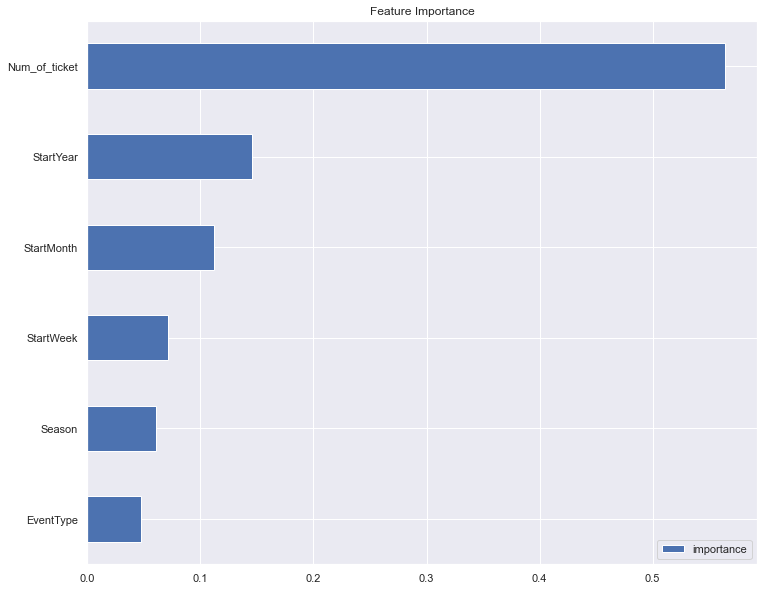

In [ ]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Forcast on Test

C:\Users\KingRemy\AppData\Local\Temp\ipykernel_9528\85181675.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Prediction'] = reg.predict(X_test_data1)


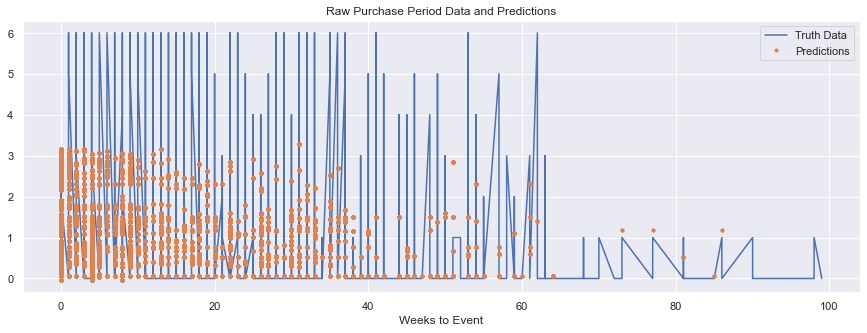

In [ ]:
test_data1['Prediction'] = reg.predict(X_test_data1)
data1 = data1.merge(test_data1[['Prediction']], how='left', left_index=True, right_index=True)
ax = data1[['Purchase_Period']].plot(figsize=(15,5))
data1['Prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Purchase Period Data and Predictions')
plt.show()